# Neural Networks Final Project Code
## Evan Callaghan, Queen's University
### Phase 1: Generating the traffic data images
Configuring setup:

In [ ]:
pip install tensorflow tensorflow-datasets

In [2]:
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D, Conv2DTranspose, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer

In [3]:
train_dir = Path("Image_Data/Training/Filled/"); train_dir.mkdir(parents = True, exist_ok = True)

train_missing_dir_5 = Path("Image_Data/Training/Missing/five/"); train_missing_dir_5.mkdir(parents = True, exist_ok = True)
train_missing_dir_15 = Path("Image_Data/Training/Missing/fifteen/"); train_missing_dir_15.mkdir(parents = True, exist_ok = True)
train_missing_dir_25 = Path("Image_Data/Training/Missing/twenty-five/"); train_missing_dir_25.mkdir(parents = True, exist_ok = True)

test_dir = Path("Image_Data/Testing/Filled/"); test_dir.mkdir(parents = True, exist_ok = True)

test_missing_dir_5 = Path("Image_Data/Testing/Missing/five/"); test_missing_dir_5.mkdir(parents = True, exist_ok = True)
test_missing_dir_15 = Path("Image_Data/Testing/Missing/fifteen/"); test_missing_dir_15.mkdir(parents = True, exist_ok = True)
test_missing_dir_25 = Path("Image_Data/Testing/Missing/twenty-five/"); test_missing_dir_25.mkdir(parents = True, exist_ok = True)

pd.set_option('display.max_columns', None, 'display.max_rows', None)

Constructing the traffic observation data-frame

In [ ]:
## Initializing traffic_data data-frame
traffic_data = pd.DataFrame()

## Concatenating each data file to traffic_data
for year in os.listdir('Traffic_Data/'):
    for file_name in os.listdir(os.path.join('Traffic_Data', year)):
        file = pd.read_csv(os.path.join('Traffic_Data', year, file_name))
        traffic_data = pd.concat([traffic_data, file], axis = 0)
        
## Changing 'Hour' variable to datetime and sorting by date
traffic_data['Hour'] = pd.to_datetime(traffic_data['Hour'])
traffic_data = traffic_data.sort_values('Hour').reset_index(drop = True)

## Reading California I-5 sensor information
all_sensors = pd.read_csv('Misc_Data/pems_sensors.csv'); all_sensors['ID'] = all_sensors['ID'].astype(str)

## Extracting columns from traffic_data data-frame
data_sensors = pd.DataFrame({'Sensor': traffic_data.drop(columns = ['Hour', '# Lane Points', '% Observed']).columns})
data_sensors['ID'] = data_sensors['Sensor'].str.split('-', n = 1, expand = True)[0].astype(str)

## Inner joining data-frames and sorting by ordering (S --> N, San Diego --> Oregon)
new_sensors = data_sensors.merge(all_sensors, how = 'inner', on = 'ID').sort_values('Ordering').reset_index(drop = True)

## Extracting proper column ordering and adding 'Hour' to the beginning
all_columns = new_sensors['Sensor'].tolist()
all_columns.insert(0, 'Hour')

## Changing column ordering of traffic_data
traffic_data = traffic_data[all_columns]

## Dropping all columns in traffic_data with missing values
traffic_data = traffic_data.dropna(axis = 'columns')

## Cutting some rows to make n_cols % 10 = 0
traffic_data = traffic_data.iloc[:, 0:461]

## Cutting some rows to make n_rows % 200 = 0
traffic_data = traffic_data.iloc[0:40000,]

## Saving 'Hour' variable
hour = traffic_data['Hour']

Data preprocessing and saving data-frames to 'Output' folder

In [ ]:
## Removing 'Hour' variable for scaling
traffic_data = traffic_data.drop(columns = ['Hour'])

## Flattening the data for quicker operations
flat_data = traffic_data.to_numpy().flatten().astype(int)

## Storing the min, max, and dimensions
minimum = np.min(flat_data); maximum = np.max(flat_data)
n = traffic_data.shape[0]; p = traffic_data.shape[1]

## Scaling data to be between 0-254
flat_data = 254 * (flat_data - minimum) / (maximum - minimum)

## Reshaping the array back to its original shape
scaled_data = pd.DataFrame(flat_data.reshape((n, p)), columns = traffic_data.columns)

In [ ]:
## Defining function to randomly remove a given proportion of observations
def delete(col, frac):
    col.loc[col.sample(frac = frac).index] = np.nan
    return col

In [ ]:
## traffic_data - complete and scaled data-frame
traffic_data = scaled_data.copy()
pd.concat([hour, traffic_data], axis = 1).to_csv('Output_Data/traffic_data.csv', index = False)

## Creating data-frames with missing values
traffic_data_missing_5 = scaled_data.apply(delete, axis = 0, frac = 0.05)
traffic_data_missing_15 = scaled_data.apply(delete, axis = 0, frac = 0.15)
traffic_data_missing_25 = scaled_data.apply(delete, axis = 0, frac = 0.25)

## traffic_data_mapped_5 - all missing values mapped to 255
traffic_data_mapped_5 = traffic_data_missing_5.fillna(value = 255)
pd.concat([hour, traffic_data_mapped_5], axis = 1).to_csv('Output_Data/traffic_data_mapped_5.csv', index = False)

## traffic_data_mapped_15 - all missing values mapped to 255
traffic_data_mapped_15 = traffic_data_missing_15.fillna(value = 255)
pd.concat([hour, traffic_data_mapped_15], axis = 1).to_csv('Output_Data/traffic_data_mapped_15.csv', index = False)

## traffic_data_mapped_25 - all missing values mapped to 255
traffic_data_mapped_25 = traffic_data_missing_25.fillna(value = 255)
pd.concat([hour, traffic_data_mapped_25], axis = 1).to_csv('Output_Data/traffic_data_mapped_25.csv', index = False)

Generating training images

In [ ]:
## Function to generate images and store to disk
def generate_training_images(df, image_dir, idx_start, idx_end):
    
    ## Initializing list to store images
    images = list()

    ## Initializing data windows
    n_time_windows = 192; n_sensor_windows = 27
    
    ## Subsetting the data-frame
    df = df.iloc[idx_start:idx_end,]

    for i in range(0, n_time_windows):
        for j in range(0, n_sensor_windows):

            ## Locking in data windows
            time_loc = [(i * 200), (i * 200 + 200)]; sensor_loc = [(j * 10), (j * 10 + 200)]

            ## Creating img with window subset
            img = np.array(df.iloc[time_loc[0]:time_loc[1], sensor_loc[0]:sensor_loc[1]])

            ## Appending to lists
            images.append(img)
    
    ## Sanity check
    print("Loaded traffic data:")
    print(f" - np.shape(images) {np.shape(images)}")
    
    ## Storing images to disk
    store_many_disk(images, image_dir)
    
def store_many_disk(images, image_dir):
    
    ## Saving images one by one
    for i, image in enumerate(images):
        storing = Image.fromarray(image)
        storing = storing.convert('L')
        storing.save(image_dir / f"{i}.png")
    print(f'-- {i+1} images saved to disk -- ')
    
## Defining indices for training set
train_idx_start = 0; train_idx_end = 38400

## Storing training images to disk
generate_training_images(traffic_data, train_dir, train_idx_start, train_idx_end)
generate_training_images(traffic_data_mapped_5, train_missing_dir_5, train_idx_start, train_idx_end)
generate_training_images(traffic_data_mapped_15, train_missing_dir_15, train_idx_start, train_idx_end)
generate_training_images(traffic_data_mapped_25, train_missing_dir_25, train_idx_start, train_idx_end)

Generating testing images

In [ ]:
## Function to generate images and store to disk
def generate_testing_images(df, image_dir, idx_start, idx_end):
    
    ## Initializing list to store images
    images = list()

    ## Initializing data windows
    n_time_windows = 2; n_sensor_windows = 5
    
    ## Subsetting the data-frame
    df = df.iloc[idx_start:idx_end,].reset_index(drop = True)

    for i in range(0, n_time_windows):
        for j in range(0, n_sensor_windows):

            ## Locking in data windows
            time_loc = [(i * 300), (i * 300 + 200)]; sensor_loc = [(j * 50), (j * 50 + 200)]

            ## Creating img with window subset
            img = np.array(df.iloc[time_loc[0]:time_loc[1], sensor_loc[0]:sensor_loc[1]])
            
            ## Appending to lists
            images.append(img)
    
    ## Sanity check
    print("Loaded traffic data:")
    print(f" - np.shape(images) {np.shape(images)}")
    
    ## Storing images to disk
    store_many_disk(images, image_dir)
    
def store_many_disk(images, image_dir):
    
    ## Saving images one by one
    for i, image in enumerate(images):
        storing = Image.fromarray(image)
        storing = storing.convert('L')
        storing.save(image_dir / f"{i}.png")
    print(f'-- {i+1} images saved to disk -- ')
    
## Defining indices for testing set
test_idx_start = 38400; test_idx_end = 40000

## Storing training images to disk
generate_testing_images(traffic_data, test_dir, test_idx_start, test_idx_end)
generate_testing_images(traffic_data_mapped_5, test_missing_dir_5, test_idx_start, test_idx_end)
generate_testing_images(traffic_data_mapped_15, test_missing_dir_15, test_idx_start, test_idx_end)
generate_testing_images(traffic_data_mapped_25, test_missing_dir_25, test_idx_start, test_idx_end)

Sanity Check: Dislaying a few sample images

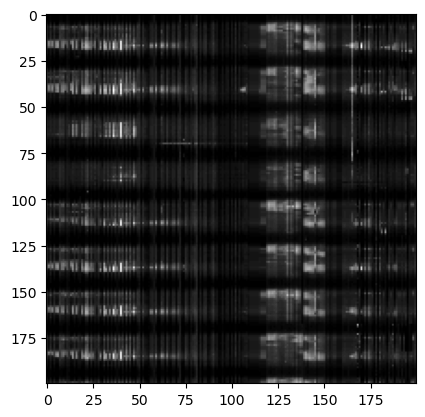

In [4]:
## Function to read n_images from disk
def read_many_disk(n_images):
    images = []
    for image_id in range(n_images):
        images.append(np.array(Image.open(train_dir / f"{image_id}.png")))
    return images

## Reading in a samplle image
n_images = 100
imgs = read_many_disk(n_images)

## Plotting an example training image
plt.imshow(imgs[99], cmap = 'gray')
plt.show()

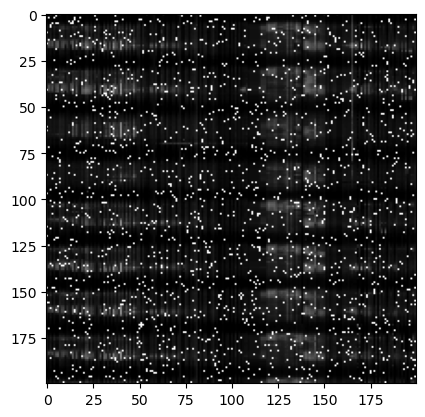

In [5]:
## Function to read n_images from disk
def read_many_disk(n_images):
    images = []
    for image_id in range(n_images):
        images.append(np.array(Image.open(train_missing_dir_5 / f"{image_id}.png")))
    return images

## Reading in a samplle image
n_images = 100
imgs = read_many_disk(n_images)

## Plotting an example training image
plt.imshow(imgs[99], cmap = 'gray')
plt.show()

All images using the traffic data are now stored on disk and ready to be used by the encoder-decoder model.

### Phase 2: Building the convolutional neural network for image encoding and decoding

Loading traffic images from directory and preprocessing the data

In [7]:
## Building the training image data sets
training_5 = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Missing/five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
training_15 = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Missing/fifteen', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
training_25 = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Missing/twenty-five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
training_target = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Filled', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)

## Building the testing image data sets
testing_5 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
testing_15 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/fifteen', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
testing_25 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/twenty-five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
testing_target = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Filled', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)

Found 5184 files belonging to 1 classes.
Found 5184 files belonging to 1 classes.
Found 5184 files belonging to 1 classes.
Found 5184 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.


In [8]:
## Scaling the data to be between 0 and 1
training_5 = training_5.map(lambda x:(x/255))
training_15 = training_15.map(lambda x:(x/255))
training_25 = training_25.map(lambda x:(x/255))
training_target = training_target.map(lambda x:(x/255))

testing_5 = testing_5.map(lambda x:(x/255))
testing_15 = testing_15.map(lambda x:(x/255))
testing_25 = testing_25.map(lambda x:(x/255))
testing_target = testing_target.map(lambda x:(x/255))

In [10]:
## Converting tf.Dataset objects to numpy arrays
def dataset_to_numpy(ds):
    images = []
    for i, image in enumerate(tfds.as_numpy(ds)): 
        images.append(image)
    return np.array(images)

## Defining the size of the training and validation sets
t_size = int(len(training_target) * 0.75)
v_size = int(len(training_target) * 0.25)

X_train_5 = dataset_to_numpy(training_5)[0:t_size]
X_train_15 = dataset_to_numpy(training_15)[0:t_size]
X_train_25 = dataset_to_numpy(training_25)[0:t_size]
Y_train = dataset_to_numpy(training_target)[0:t_size]

X_val_5 = dataset_to_numpy(training_5)[t_size:(t_size + v_size)]
X_val_15 = dataset_to_numpy(training_15)[t_size:(t_size + v_size)]
X_val_25 = dataset_to_numpy(training_25)[t_size:(t_size + v_size)]
Y_val = dataset_to_numpy(training_target)[t_size:(t_size + v_size)]

X_test_5 = dataset_to_numpy(testing_5)
X_test_15 = dataset_to_numpy(testing_15)
X_test_25 = dataset_to_numpy(testing_25)
Y_test = dataset_to_numpy(testing_target)

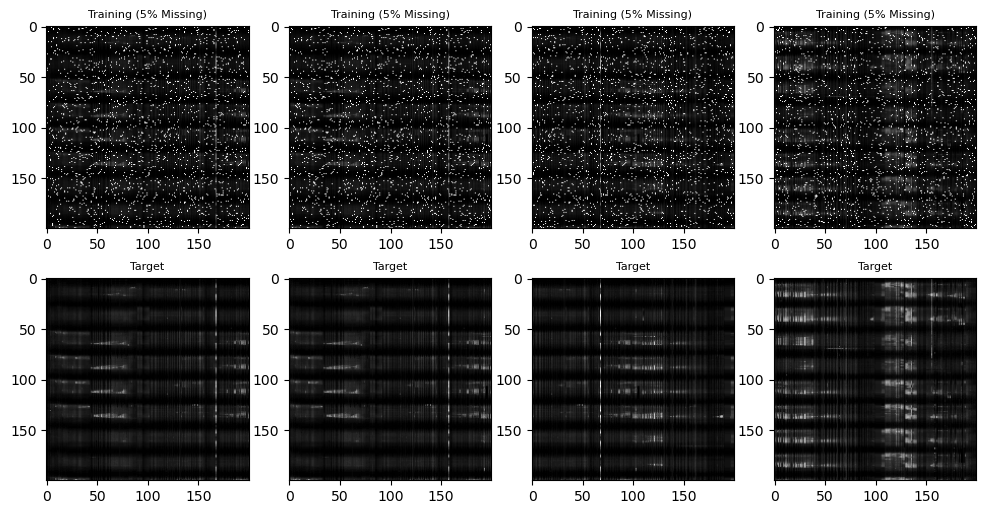

In [11]:
## Visualizing four sample training images 
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (12,6))
for i in range(0, 4):
    ax[0, i].imshow(X_train_5[i], cmap = 'gray'); ax[0, i].set_title('Training (5% Missing)', size = 8)
    ax[1, i].imshow(Y_train[i], cmap = 'gray'); ax[1, i].set_title('Target', fontsize = 8)

Constructing the auto-encoder

In [12]:
## Defining the Sequential model
autoencoder = Sequential(name = 'Autoencoder')

## Input Layer
autoencoder.add(Input(shape=(200, 200, 1), name = 'Input'))

## Convo-Pooling Layer 1
autoencoder.add(Conv2D(20, (9,9), 1, data_format = 'channels_last', name = 'Conv_1'))
autoencoder.add(MaxPooling2D(pool_size = (4,4), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_1'))

## Convo-Pooling Layer 2
autoencoder.add(Conv2D(60, (9,9), 1, data_format = 'channels_last', name = 'Conv_2'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_2'))

## Convo-Pooling Layer 3
autoencoder.add(Conv2D(180, (9,9), 1, data_format = 'channels_last', name = 'Conv_3'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_3'))

## Fully-Connected Layer
autoencoder.add(Dense(18, activation = 'relu', name = 'Dense_1', use_bias = False))
autoencoder.add(Dense(180, activation = 'relu', name = 'Dense_2', use_bias = False))

## Up Convo-Pooling Layer 1
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_1'))
autoencoder.add(Conv2DTranspose(180, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_1'))

##Up Convo-Pooling Layer 2
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_2'))
autoencoder.add(Conv2DTranspose(60, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_2'))

## Up Convo-Pooling Layer 3
autoencoder.add(UpSampling2D(size = (4,4), data_format = 'channels_last', name = 'Up_Max_3'))
autoencoder.add(Conv2DTranspose(20, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_3'))

## Output Layer
autoencoder.add(Conv2D(1, (3, 3), activation = 'relu', padding = 'same',  data_format = 'channels_last', name = 'Output'))

In [13]:
## Compiling the Sequential model
autoencoder.compile(optimizer = 'adam', loss = tf.losses.MeanSquaredError())

## Printing a model summary
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 192, 192, 20)      1640      
                                                                 
 Max_1 (MaxPooling2D)        (None, 48, 48, 20)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 40, 40, 60)        97260     
                                                                 
 Max_2 (MaxPooling2D)        (None, 20, 20, 60)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 12, 12, 180)       874980    
                                                                 
 Max_3 (MaxPooling2D)        (None, 6, 6, 180)         0         
                                                                 
 Dense_1 (Dense)             (None, 6, 6, 18)          

Fitting the autoencoder model on the data with 5% missing ratio

In [ ]:
autoencoder.fit(X_train_5, Y_train, epochs = 5, batch_size = 32, shuffle = True, validation_data = (X_val_5, Y_val))

Predicting on the testing data and saving the trained model

In [ ]:
testing_preds_5 = autoencoder.predict(X_test_5)
autoencoder.save(os.path.join('Models', 'autoencoder_missing_5.h5'))

In [14]:
## Loading the model
autoencoder_5 = load_model(os.path.join('Models', 'autoencoder_missing_5.h5'))

## Predicting on the test sets
testing_preds_5 = autoencoder_5.predict(X_test_5)

1/1 [==============================] - 1s 1s/step


Visualizing some predictions

In [15]:
## Flattening the data-frames for easier computation
X_test_flat = np.squeeze(X_test_5[1]).flatten()
preds_flat = np.squeeze(testing_preds_5[1]).flatten()

## Recording the indexes where Y_train had a missing value
missing_idx = np.argwhere(X_test_flat == 1.0)

## Filling in the missing values with the imputed pixel value 
X_test_flat[missing_idx] = preds_flat[missing_idx]

## Returning the data-frames back to their original shape
X_test_imputed = X_test_flat.reshape(200, 200)

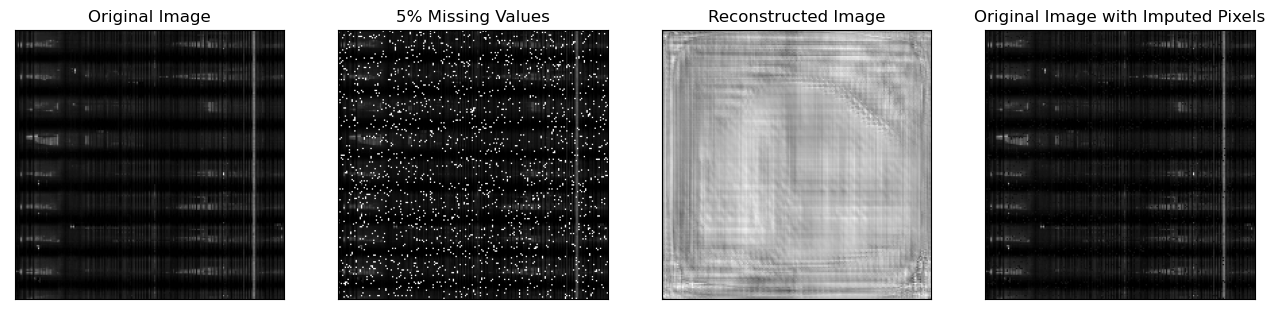

In [16]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 4, 1)
plt.imshow(tf.squeeze(Y_test[1]), cmap = 'gray')
plt.title("Original Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 2)
plt.imshow(tf.squeeze(X_test_5[1]), cmap = 'gray')
plt.title("5% Missing Values", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 3)
plt.imshow(tf.squeeze(testing_preds_5[1]), cmap = 'gray')
plt.title("Reconstructed Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 4)
plt.imshow(tf.squeeze(X_test_imputed), cmap = 'gray')
plt.title("Original Image with Imputed Pixels", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Fitting the autoencoder model on the data with 15% missing ratio

In [ ]:
autoencoder.fit(X_train_15, Y_train, epochs = 5, batch_size = 32, shuffle = True, validation_data = (X_val_15, Y_val))

Predicting on the testing data and saving the trained model

In [ ]:
testing_preds_15 = autoencoder.predict(X_test_15)
autoencoder.save(os.path.join('Models', 'autoencoder_missing_15.h5'))

In [17]:
## Loading the model
autoencoder_15 = load_model(os.path.join('Models', 'autoencoder_missing_15.h5'))

## Predicting on the test sets
testing_preds_15 = autoencoder_15.predict(X_test_15)

1/1 [==============================] - 1s 1s/step


Visualizing some predictions

In [18]:
## Flattening the data-frames for easier computation
X_test_flat = np.squeeze(X_test_15[5]).flatten()
preds_flat = np.squeeze(testing_preds_15[5]).flatten()

## Recording the indexes where Y_train had a missing value
missing_idx = np.argwhere(X_test_flat == 1.0)

## Filling in the missing values with the imputed pixel value 
X_test_flat[missing_idx] = preds_flat[missing_idx]

## Returning the data-frames back to their original shape
X_test_imputed = X_test_flat.reshape(200, 200)

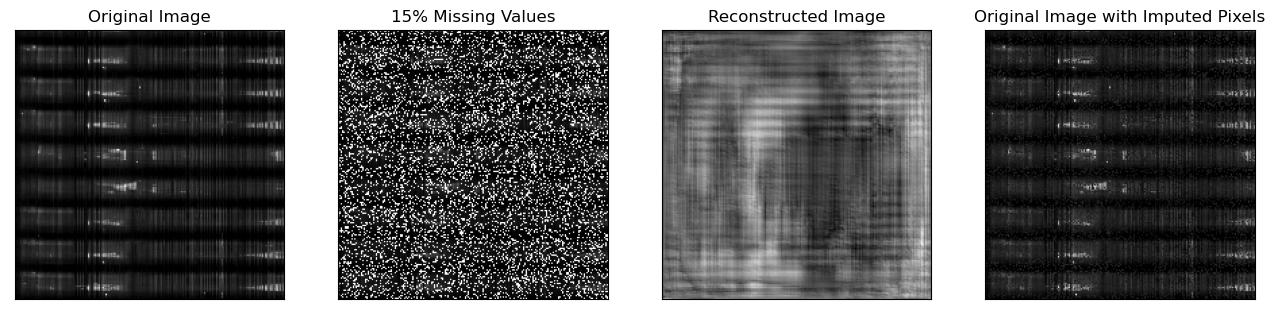

In [19]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 4, 1)
plt.imshow(tf.squeeze(Y_test[5]), cmap = 'gray')
plt.title("Original Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 2)
plt.imshow(tf.squeeze(X_test_15[5]), cmap = 'gray')
plt.title("15% Missing Values", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 3)
plt.imshow(tf.squeeze(testing_preds_15[5]), cmap = 'gray')
plt.title("Reconstructed Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 4)
plt.imshow(tf.squeeze(X_test_imputed), cmap = 'gray')
plt.title("Original Image with Imputed Pixels", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Fitting the autoencoder model on the data with 25% missing ratio

In [ ]:
autoencoder.fit(X_train_25, Y_train, epochs = 5, batch_size = 32, shuffle = True, validation_data = (X_val_25, Y_val))

Predicting on the testing data and saving the trained model

In [ ]:
testing_preds_25 = autoencoder.predict(X_test_25)
autoencoder.save(os.path.join('Models', 'autoencoder_missing_25.h5'))

In [20]:
## Loading the model
autoencoder_25 = load_model(os.path.join('Models', 'autoencoder_missing_25.h5'))

## Predicting on the test sets
testing_preds_25 = autoencoder_25.predict(X_test_25)

1/1 [==============================] - 1s 1s/step


Visualizing some predictions

In [21]:
## Flattening the data-frames for easier computation
X_test_flat = np.squeeze(X_test_25[8]).flatten()
preds_flat = np.squeeze(testing_preds_25[8]).flatten()

## Recording the indexes where Y_train had a missing value
missing_idx = np.argwhere(X_test_flat == 1.0)

## Filling in the missing values with the imputed pixel value 
X_test_flat[missing_idx] = preds_flat[missing_idx]

## Returning the data-frames back to their original shape
X_test_imputed = X_test_flat.reshape(200, 200)

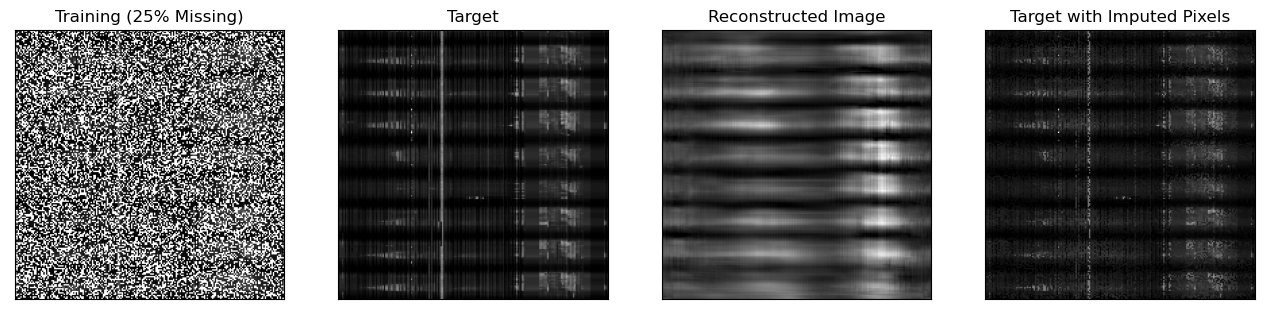

In [22]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 4, 2)
plt.imshow(tf.squeeze(Y_test[8]), cmap = 'gray')
plt.title("Target", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 1)
plt.imshow(tf.squeeze(X_test_25[8]), cmap = 'gray')
plt.title("Training (25% Missing)", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 3)
plt.imshow(tf.squeeze(testing_preds_25[8]), cmap = 'gray')
plt.title("Reconstructed Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 4)
plt.imshow(tf.squeeze(X_test_imputed), cmap = 'gray')
plt.title("Target with Imputed Pixels", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Phase 3: Comparing the CNN imputer with other methods of data imputation

In [23]:
## Reading the traffic data-frames
traffic_data = pd.read_csv('Output_Data/traffic_data.csv').drop(columns = ['Hour'])
traffic_data_5 = pd.read_csv('Output_Data/traffic_data_mapped_5.csv').drop(columns = ['Hour'])
traffic_data_15 = pd.read_csv('Output_Data/traffic_data_mapped_15.csv').drop(columns = ['Hour'])
traffic_data_25 = pd.read_csv('Output_Data/traffic_data_mapped_25.csv').drop(columns = ['Hour'])
hour = pd.read_csv('Output_Data/traffic_data.csv')['Hour']

In [24]:
## Subsetting the data-frame to only account for the testing data
def creating_test(data):
    data_1 = data.iloc[38400:38600, 0:200]
    data_2 = data.iloc[38400:38600, 50:250]; data_2.columns = data_1.columns
    data_3 = data.iloc[38400:38600, 100:300]; data_3.columns = data_1.columns
    data_4 = data.iloc[38400:38600, 150:350]; data_4.columns = data_1.columns
    data_5 = data.iloc[38400:38600, 200:400]; data_5.columns = data_1.columns
    data_6 = data.iloc[38700:38900, 0:200]; data_6.columns = data_1.columns
    data_7 = data.iloc[38700:38900, 50:250]; data_7.columns = data_1.columns
    data_8 = data.iloc[38700:38900, 100:300]; data_8.columns = data_1.columns
    data_9 = data.iloc[38700:38900, 150:350]; data_9.columns = data_1.columns
    data_10 = data.iloc[38700:38900, 200:400]; data_10.columns = data_1.columns
    
    return pd.concat([data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10], axis = 0, ignore_index = True)

test = creating_test(traffic_data)
test_5 = creating_test(traffic_data_5)
test_15 = creating_test(traffic_data_15)
test_25 = creating_test(traffic_data_25)

In [25]:
## Saving the original dimensions
n = test.shape[0]; p = test.shape[1]

## Scaling the values to be between 0 and 1
test = test / 255.
test_5 = test_5 / 255.
test_15 = test_15 / 255.
test_25 = test_25 / 255.

## Flattening the data-frames for easier computation
test_flat = np.array(test).flatten()
test_5_flat = np.array(test_5).flatten()
test_15_flat = np.array(test_15).flatten()
test_25_flat = np.array(test_25).flatten()

In [26]:
## Recording the indices where each data-frame has missing values
missing_idx_5 = np.argwhere(test_5_flat == 1.0)
missing_idx_15 = np.argwhere(test_15_flat == 1.0)
missing_idx_25 = np.argwhere(test_25_flat == 1.0)

## Extracting the true values for these indices
Y_true_5 = test_flat[missing_idx_5]
Y_true_15 = test_flat[missing_idx_15]
Y_true_25 = test_flat[missing_idx_25]

In [27]:
## Defining MSE and MAE functions
def imputed_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred, squared = False)

def imputed_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def evaluation(Y_true, Y_pred):
    MSE = imputed_mse(Y_true, Y_pred); MAE = imputed_mae(Y_true, Y_pred)
    return MSE, MAE

Implementing Mean Imputation

In [28]:
def mean_imputer(col):
    col = np.where(col == 1.0, np.mean(col), col)
    return col

mean_imputed_5 = np.array(test_5.copy().apply(mean_imputer, axis = 0)).flatten()
mean_imputed_15 = np.array(test_15.copy().apply(mean_imputer, axis = 0)).flatten()
mean_imputed_25 = np.array(test_25.copy().apply(mean_imputer, axis = 0)).flatten()

mean_imputed_5 = mean_imputed_5[missing_idx_5]
mean_imputed_15 = mean_imputed_15[missing_idx_15]
mean_imputed_25 = mean_imputed_25[missing_idx_25]

mean_imputer_mse_5, mean_imputer_mae_5 = evaluation(Y_true_5, mean_imputed_5)
mean_imputer_mse_15, mean_imputer_mae_15 = evaluation(Y_true_15, mean_imputed_15)
mean_imputer_mse_25, mean_imputer_mae_25 = evaluation(Y_true_25, mean_imputed_25)

In [29]:
print(mean_imputer_mse_5, mean_imputer_mae_5)
print(mean_imputer_mse_15, mean_imputer_mae_15)
print(mean_imputer_mse_25, mean_imputer_mae_25)

0.07218351176284994 0.0621945119327031
0.18936397012535888 0.1826827449448754
0.37673951216375035 0.3725806209333507


Implementing Last Observation Carried Forward Imputation

In [30]:
def locf_imputer(data, missing_idx):
    
    for idx in missing_idx:
        i = 1
        while np.isnan(data[idx-i]):
            i += 1
        data[idx] = data[idx-i]
    return data

locf_imputed_5 = locf_imputer(test_5_flat, missing_idx_5)[missing_idx_5]
locf_imputed_15 = locf_imputer(test_15_flat, missing_idx_15)[missing_idx_15]
locf_imputed_25 = locf_imputer(test_25_flat, missing_idx_25)[missing_idx_25]

locf_imputer_mse_5, locf_imputer_mae_5 = evaluation(Y_true_5, locf_imputed_5)
locf_imputer_mse_15, locf_imputer_mae_15 = evaluation(Y_true_15, locf_imputed_15)
locf_imputer_mse_25, locf_imputer_mae_25 = evaluation(Y_true_25, locf_imputed_25)

In [31]:
print(locf_imputer_mse_5, locf_imputer_mae_5)
print(locf_imputer_mse_15, locf_imputer_mae_15)
print(locf_imputer_mse_25, locf_imputer_mae_25)

0.047665757804141416 0.028792922327641437
0.04896604390340701 0.028787880205107648
0.04905412311377215 0.02859197169077984


Implementing linear imputation

In [32]:
def linear_imputer(data, missing_idx):
    
    for idx in missing_idx:
        a = 1
        while np.isnan(data[idx-a]):
            a += 1
        if idx < 1999:
            b = 1
            while np.isnan(data[idx+b]):
                b += 1
        else: b = -1
        data[idx] = (data[idx-a] + data[idx+b]) / 2
    return data

linear_imputed_5 = linear_imputer(test_5_flat, missing_idx_5)[missing_idx_5]
linear_imputed_15 = linear_imputer(test_15_flat, missing_idx_15)[missing_idx_15]
linear_imputed_25 = linear_imputer(test_25_flat, missing_idx_25)[missing_idx_25]

linear_imputer_mse_5, linear_imputer_mae_5 = evaluation(Y_true_5, linear_imputed_5)
linear_imputer_mse_15, linear_imputer_mae_15 = evaluation(Y_true_15, linear_imputed_15)
linear_imputer_mse_25, linear_imputer_mae_25 = evaluation(Y_true_25, linear_imputed_25)

In [33]:
print(linear_imputer_mse_5, linear_imputer_mae_5)
print(linear_imputer_mse_15, linear_imputer_mae_15)
print(linear_imputer_mse_25, linear_imputer_mae_25)

0.04763166991027036 0.028764585305371203
0.04894656657960593 0.028771779454545048
0.049039864831082074 0.02857927656082212


Implementing K-Nearest Neighbours Imputation

In [34]:
def knn_imputer(data):
    return KNNImputer(n_neighbors = 5).fit_transform(data)

knn_test_5 = pd.DataFrame(np.where(test_5 == 1.0, np.nan, test_5))
knn_test_15 = pd.DataFrame(np.where(test_15 == 1.0, np.nan, test_15))
knn_test_25 = pd.DataFrame(np.where(test_25 == 1.0, np.nan, test_25))

knn_imputed_5 = np.array(knn_imputer(knn_test_5)).flatten()
knn_imputed_15 = np.array(knn_imputer(knn_test_15)).flatten()
knn_imputed_25 = np.array(knn_imputer(knn_test_25)).flatten()

knn_imputed_5 = knn_imputed_5[missing_idx_5]
knn_imputed_15 = knn_imputed_15[missing_idx_15]
knn_imputed_25 = knn_imputed_25[missing_idx_25]

knn_imputer_mse_5, knn_imputer_mae_5 = evaluation(Y_true_5, knn_imputed_5)
knn_imputer_mse_15, knn_imputer_mae_15 = evaluation(Y_true_15, knn_imputed_15)
knn_imputer_mse_25, knn_imputer_mae_25 = evaluation(Y_true_25, knn_imputed_25)

In [35]:
print(knn_imputer_mse_5, knn_imputer_mae_5)
print(knn_imputer_mse_15, knn_imputer_mae_15)
print(knn_imputer_mse_25, knn_imputer_mae_25)

0.014627465349682539 0.0067148210435888905
0.016012078773996522 0.007137554354688584
0.016890113861044456 0.007599799902760303


Implementing CNN based imputation

In [36]:
## Reading the testing image data sets
testing_5 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
testing_15 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/fifteen', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
testing_25 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/twenty-five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)
testing_target = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Filled', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = False)

Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.


In [37]:
## Scaling the data to be between 0 and 1
testing_5 = testing_5.map(lambda x:(x/255))
testing_15 = testing_15.map(lambda x:(x/255))
testing_25 = testing_25.map(lambda x:(x/255))
testing_target = testing_target.map(lambda x:(x/255))

In [42]:
## Converting tf.Dataset objects to numpy arrays
def dataset_to_numpy(ds):
    images = []
    for i, image in enumerate(tfds.as_numpy(ds)): 
        images.append(image)
    return np.array(images)

X_test_5 = dataset_to_numpy(testing_5)
X_test_15 = dataset_to_numpy(testing_15)
X_test_25 = dataset_to_numpy(testing_25)
Y_test = dataset_to_numpy(testing_target)

In [43]:
## Loading the CNN models
autoencoder_5 = load_model(os.path.join('Models', 'autoencoder_missing_5.h5'))
autoencoder_15 = load_model(os.path.join('Models', 'autoencoder_missing_15.h5'))
autoencoder_25 = load_model(os.path.join('Models', 'autoencoder_missing_25.h5'))

## Predicting on the test sets
testing_preds_5 = autoencoder_5.predict(X_test_5)
testing_preds_15 = autoencoder_15.predict(X_test_15)
testing_preds_25 = autoencoder_25.predict(X_test_25)

1/1 [==============================] - 1s 1s/step


In [44]:
## Defining MSE and MAE functions specifically for CNN predictions
def imputed_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred, squared = False)

def imputed_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def evaluation(X, Y, preds):
    mse = list(); mae = list()
    
    for i in range(len(preds)):
        
        ## Flattening the arrays 
        X_flat = np.squeeze(X[i]).flatten()
        Y_flat = np.squeeze(Y[i]).flatten()
        preds_flat = np.squeeze(preds[i]).flatten()
        
        ## Finding the index of imputed values
        missing_idx = np.argwhere(X_flat == 1.0)
        
        ## Extracting the Y_true and Y_pred values
        Y_true = Y_flat[missing_idx]
        Y_pred = preds_flat[missing_idx]
        
        ## Computing the metrics:
        mse.append(imputed_mse(Y_true, Y_pred))
        mae.append(imputed_mae(Y_true, Y_pred))
        
    return mse, mae

CNN_imputer_mse_5, CNN_imputer_mae_5 = evaluation(X_test_5, Y_test, testing_preds_5)
CNN_imputer_mse_15, CNN_imputer_mae_15 = evaluation(X_test_15, Y_test, testing_preds_15)
CNN_imputer_mse_25, CNN_imputer_mae_25 = evaluation(X_test_25, Y_test, testing_preds_25)

In [45]:
print(np.mean(CNN_imputer_mse_5), np.mean(CNN_imputer_mae_5))
print(np.mean(CNN_imputer_mse_15), np.mean(CNN_imputer_mae_15))
print(np.mean(CNN_imputer_mse_25), np.mean(CNN_imputer_mae_25))

0.054222204 0.039396655
0.05440126 0.039853774
0.04645601 0.03036653
